# Ego4D Annotation Visualizations
This notebook has visualizations for Ego4D's different annotation types

## Prerequisites
1. Use the [Ego4D CLI](https://ego4d-data.org/docs/start-here/) to download the annotations and full_scale datasets. This notebook expects all videos to be downloaded, but you can manually download them as you go.
2. Install all the packages in this notebook using `requirements.txt`.

## **Useful Links:**

[Ego4D Docs - Start Here!](https://ego4d-data.org/docs/start-here/#Download-The-CLI)

[Data Overview](https://ego4d-data.org/docs/data-overview/)

[Official Ego4D Site](https://ego4d-data.org/)

# Setup

In [1]:
import os
# Set your options here
# Sampled Videos will be downloaded to <version>/full_scale/ if they aren't already there

CLI_OUTPUT_DIR = "/Users/<userid>/ego4d_data" # Replace with the full path to the --output_directory you pass to the cli
VERSION = "v1"
MANIFEST_PATH = os.path.join(CLI_OUTPUT_DIR, VERSION, 'manifest.csv') # Use this if manifest is at <version>/manifest.csv
# MANIFEST_PATH = os.path.join(CLI_OUTPUT_DIR, VERSION, 'full_scale' ,'manifest.csv') # Use this if manifest is at <version>/full_scale/

assert os.path.exists(MANIFEST_PATH), f"Manifest doesn't exist at {MANIFEST_PATH}. Is the CLI_OUTPUT_DIR right? Do you satisfy the pre-requisites?"

In [2]:
# Setup
import sys
if os.path.abspath(".") not in sys.path: # Allow us to use util files in the same dir
    sys.path.insert(0, os.path.abspath("."))

import av
import collections
import csv
import cv2
import functools
import json
import logging
import math
import matplotlib.collections as mc
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd
import random
import uuid
import warnings

from celluloid import Camera
from IPython.display import HTML
from iopath.common.file_io import PathManager
from itertools import groupby
from pprint import pprint
from nb_video_utils import _get_frames

%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"

pathmgr = PathManager()

warnings.filterwarnings('ignore')

def vid_df_des(df):
    return f"#{len(df)} {df.duration_sec.sum()/60/60:.1f}h"
def vid_des(videos):
    return f"#{len(videos)} {sum((x.duration_sec for x in videos))/60/60:.1f}h"
def deserialize_str_list(list_: str):
    list_ = list_[1:-2]
    items = list_.split("', '")
    return list(map(lambda z: z.strip("'"), items))
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

# Video API


In [3]:
videos_df = pd.read_csv(MANIFEST_PATH)
videos_df['scenarios'] = videos_df['scenarios'].apply(deserialize_str_list)
def get_video(video_uid):
    return videos_df.loc[videos_df['video_uid'] == '353ae622-c322-443e-95b4-e9927dedfa1c'].iloc[0]
print(f"R1 Videos: {vid_df_des(videos_df)}")

R1 Videos: #9650 3877.9h


# Visualization Utils

In [4]:
# in: video_path, frame_number, boxes: [{ object_type, bbox: {x, y, width, height} }]}, draw_labels
# out: path to image of bboxes rendered onto the video frame
def render_frame_with_bboxes(video_path, frame_number, boxes, draw_labels = True):
    colormap = { # Custom colors for FHO annotations
        'object_of_change': (0, 255, 255),
        'left_hand': (0, 0, 255),
        'right_hand': (0, 255, 0)
    }
    defaultColor = (255, 255, 0)
    rect_thickness = 5
    rectLineType = cv2.LINE_4
    fontColor = (0, 0, 0)
    fontFace = cv2.FONT_HERSHEY_DUPLEX
    fontScale = 1
    fontThickness = 1
    with av.open(video_path) as input_video:
        frames = list(_get_frames([frame_number], input_video, include_audio=False, audio_buffer_frames=0))
        assert len(frames) == 1
        img = frames[0].to_ndarray(format="bgr24")
        for box in boxes:
            label, bbox = box['object_type'], box['bbox']
            rectColor = colormap.get(label, defaultColor) if label else defaultColor
            x, y, width, height = list(map(lambda x: int(x), [bbox['x'], bbox['y'], bbox['width'], bbox['height']]))
            cv2.rectangle(img, pt1=(x,y), pt2=(x+width, y+height), color=rectColor, thickness=rect_thickness, lineType=rectLineType)
            if label and draw_labels:
                textSize, baseline = cv2.getTextSize(label, fontFace, fontScale, fontThickness)
                textWidth, textHeight = textSize
                cv2.rectangle(img, pt1=(x - rect_thickness//2, y - rect_thickness//2), pt2=(x + textWidth + 10 + rect_thickness, y - textHeight - 10 - rect_thickness), color=rectColor, thickness=-1)
                cv2.putText(img, text=label, org=(x + 10, y - 10), fontFace=fontFace, fontScale=fontScale, color=fontColor, thickness=fontThickness, lineType=cv2.LINE_AA)
    path = f"/tmp/{frame_number}_{str(uuid.uuid1())}.jpg"
    cv2.imwrite(path, img)
    return path

# in: video_path, frames: [{ frame_number, frame_type, boxes: [{ object_type, bbox: {x, y, width, height} }] }]
# out: void; as a side-effect, renders frames from the video with matplotlib
def plot_frames_with_bboxes(video_path, frames, max_cols = 3):
    cols = min(max_cols, len(frames))
    rows = math.ceil(len(frames) / cols)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10*cols, 7 * rows))
    if len(frames) > 1:
        [axi.set_axis_off() for axi in axes.ravel()] # Hide axes
    for idx, frame_data in enumerate(frames):
        row = idx // max_cols
        col = idx % max_cols
        frame_path = render_frame_with_bboxes(video_path, frame_data['frame_number'], frame_data['boxes'])
        axes[row, col].title.set_text(frame_data['frame_type'])
        axes[row, col].imshow(mpimg.imread(frame_path, format='jpeg'))
    plt.subplots_adjust(wspace=.05, hspace=.05)
    plt.show()
    
# in: video_path, frames: [{ frame_number, frame_label, ?boxes: [{ label, bbox: {x, y, width, height }}] }]
# out: matplotlib.ArtistAnimation of frames rendered with bounding boxes (if provided)
def render_frames_animation(video_path, frames, **kwargs):
    fig, ax = plt.subplots(figsize=(15, 9))
    camera = Camera(fig)
    for frame in frames:
        boxes = frame.get('boxes', [])
        frame_path = render_frame_with_bboxes(video_path, frame['frame_number'], boxes)
        ax.text(0, 1.01, frame['frame_label'], fontsize=20.0, transform=ax.transAxes)
        plt.imshow(mpimg.imread(frame_path, format='jpeg'))
        camera.snap()
    plt.close(fig)
    return camera.animate(**kwargs)

# in: segments: [{<start_key>: int, <end_key>: int}]
# out: void; as a side effect, renders a plot showing all segments passed in
def plot_segments(segments, start_key, end_key):
    ordered_segs = sorted(segments, key=lambda x: x[start_key])
    lines = [[(x[start_key], i), (x[end_key], i)] for i, x in enumerate(ordered_segs)]

    lc = mc.LineCollection(lines, linewidths=2)
    fig, ax = plt.subplots(figsize=(30, 10))
    ax.add_collection(lc)
    ax.autoscale()
    ax.set_xlabel('Frame', fontsize=15)
    ax.set_ylabel('Segment', fontsize=15)
    start, end = ax.get_xlim()
    stepsize = (end-start)/30
    ax.xaxis.set_ticks(np.arange(start, end, stepsize))
    plt.show()
    
# in: track: [ [{<start_key>: int, <end_key>: int, <label>: str}] ]
# out: void; as a side effect, renders a plot showing segments of each track passed in
def plot_multitrack_segments(tracks, start_key, end_key, label_key):
    cmap = plt.cm.get_cmap('tab20')
    color_palette = [cmap(x) for x in range(0, 20)]
    
    lines, colors, patches = [], [], []
    for i, segments in enumerate(tracks):
        lines += [[(x[start_key], i), (x[end_key], i)] for x in segments]
        color = color_palette[i % len(color_palette)]
        colors += [color for _ in segments]
        patches += [mpatches.Patch(color=color, label=segments[0][label_key])]

    lc = mc.LineCollection(lines, colors = colors, linewidths=550/len(tracks))
    fig, ax = plt.subplots(figsize=(30, 10))
    ax.legend(handles=patches, loc='upper left')
    ax.add_collection(lc)
    ax.autoscale()
    ax.set_xlabel('Frame', fontsize=15)
    ax.set_ylabel('Track', fontsize=15)
    start, end = ax.get_xlim()
    stepsize = (end-start)/30
    ax.xaxis.set_ticks(np.arange(start, end, stepsize))
    plt.show()

***

# Forecasting Hands and Objects (FHO)
A **video** has one or more **intervals** which contain **actions** made up of **frames** which define **bounding boxes**.

[Data Overview](https://ego4d-data.org/docs/benchmarks/hands-and-objects/)


In [5]:
# Load FHO
with pathmgr.open(os.path.join(CLI_OUTPUT_DIR, VERSION, 'annotations', 'fho.json'), "r") as f:
    fho_annotations = json.load(f)
    fho_ann_video_uids = list(fho_annotations['video_data'].keys())
print(f"FHO: {len(fho_ann_video_uids)} videos - top level: {fho_annotations.keys()}")

FHO: 1088 videos - top level: dict_keys(['video_data', 'warning_descriptions', 'rejection_descriptions', 'state_changes', 'unmapped_nouns', 'unmapped_verbs', 'canonical_version'])


In [6]:
# Sample one video
fho_video_uid = random.sample(fho_ann_video_uids, 1)[0]
fho_video = videos_df[videos_df.video_uid == fho_video_uid].iloc[0]
print(f"Sampled Video: {fho_video}")

Sampled Video: video_uid                                        8ea8bd4d-8778-4a0e-81aa-3f34044ce7ca
path                                s3://ego4d-unict/public/v1/full_scale/8ea8bd4d...
duration_sec                                                                    903.3
scenarios                                 [Crafting/knitting/sewing/drawing/painting]
split_em                                                                          NaN
split_av                                                                          NaN
split_fho                                                                        test
benchmarks                                                                      [FHO]
origin_video_id                                                        unict_012_0053
video_source                                                                    unict
device                                                            GoPro Hero Silver 7
deid_scrubbed_audio                    

In [7]:
# Summarize FHO Annotations
fho_video_annotations = fho_annotations['video_data'].get(fho_video_uid)
annotation_intervals = fho_video_annotations['annotated_intervals']
print(f"Video Intervals: {len(annotation_intervals)}, uid: {fho_video_uid}")
for interval in annotation_intervals:
    print(f"Interval [{interval['start_sec']} - {interval['end_sec']}]")
    actions = list(filter(lambda x: not (x['is_invalid_annotation'] or x['is_rejected']) and x['stage'] is not None, interval['narrated_actions']))
    print(f"Actions: {len(actions)}")

Video Intervals: 1, uid: 8ea8bd4d-8778-4a0e-81aa-3f34044ce7ca
Interval [600.0 - 900.0]
Actions: 56


In [11]:
# If this errors out, make sure you used the cli to download the video with this uid
fho_video_path = os.path.join(CLI_OUTPUT_DIR, VERSION, 'full_scale', fho_video_uid + '.mp4')
assert os.path.exists(fho_video_path), f"Video {fho_video_uid} not found. Download it with the cli using: python3 -m ego4d.cli.cli --output_directory=\"<output_dir>\" --datasets full_scale --video_uids={fho_video_uid} --yes"

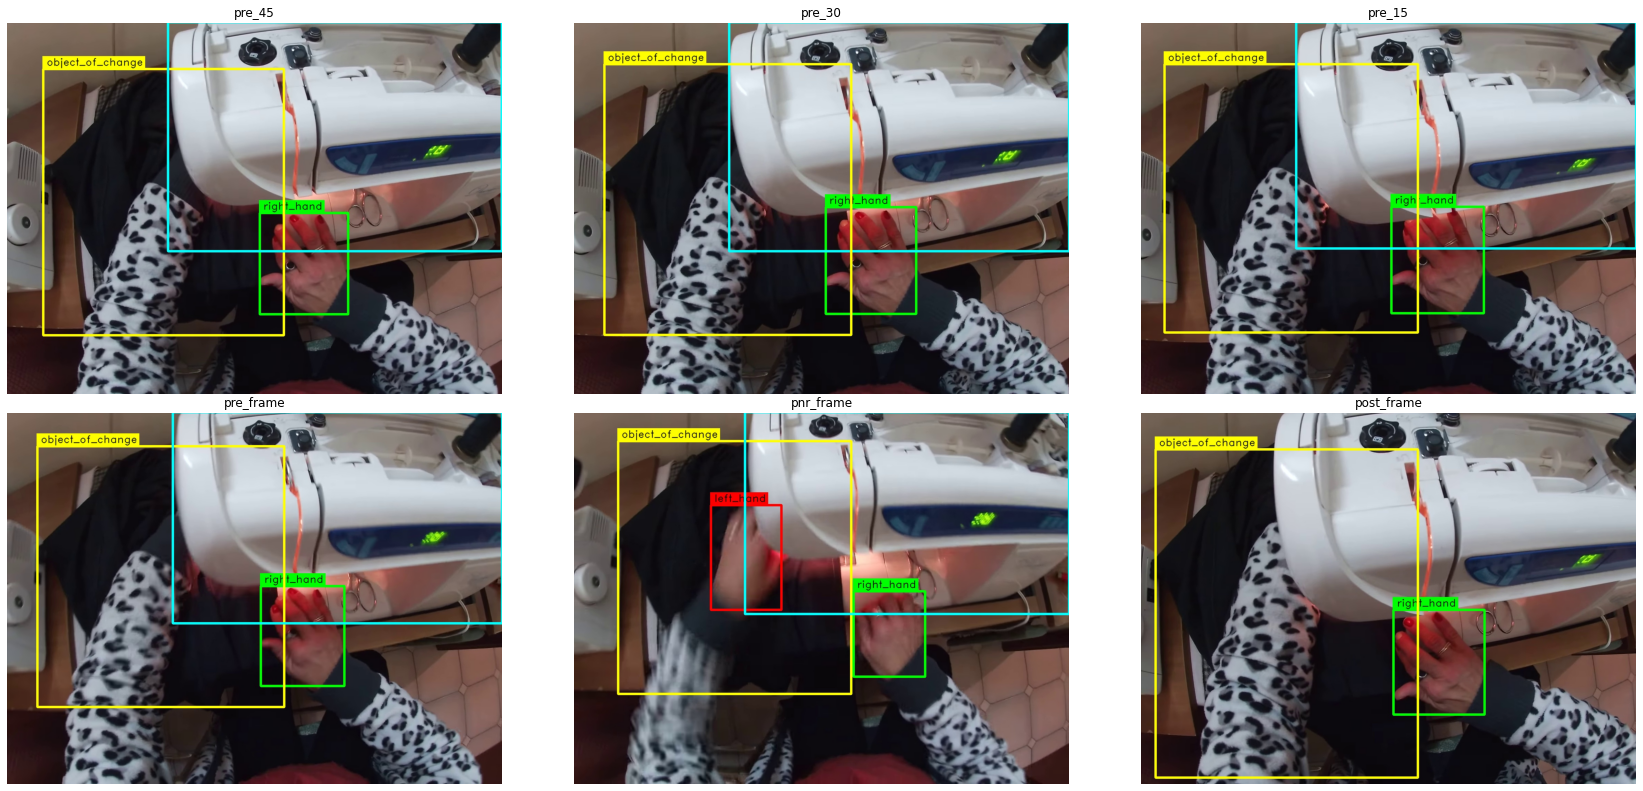

In [12]:
# Display critical frames for an action as a grid
frame_order = ['pre_45', 'pre_30', 'pre_15', 'pre_frame', 'contact_frame', 'pnr_frame', 'post_frame']

interval = random.sample(fho_video_annotations['annotated_intervals'], 1)[0]
actions = list(filter(lambda x: not (x['is_invalid_annotation'] or x['is_rejected']) and x['stage'] is not None, interval['narrated_actions']))
action = random.sample(actions, 1)[0]
frames = sorted(action['frames'], key=lambda x: frame_order.index(x['frame_type']))
plot_frames_with_bboxes(fho_video_path, frames)

In [ ]:
# Display critical frames as an animation
labeled_frames = list(map(
    lambda frame:
        {
            'frame_label': f"{frame['frame_type']}:{frame['frame_number']}",
            **frame
        }, frames))
render_frames_animation(fho_video_path, labeled_frames, interval=500)

In [15]:
# Select a single frame
sample_frame_priority = ['contact_frame', 'pnr_frame', 'pre_frame', 'post_frame', 'pre_15', 'pre_30', 'pre_45']
sample_frame = sorted(action['frames'], key=lambda x: sample_frame_priority.index(x['frame_type']))[0]

In [ ]:
# Display bounding boxes on a single frame
sample_frame_path = render_frame_with_bboxes(fho_video_path, sample_frame['frame_number'], sample_frame['boxes'])
plt.rcParams['figure.figsize'] = [20, 20]
plt.title(sample_frame['frame_type'])
plt.axis('off')
plt.imshow(mpimg.imread(sample_frame_path, format='jpeg'))
plt.show()

***

# Visual Object Queries (VQ)
[Data Overview](https://ego4d-data.org/docs/data-overview/#visual-object-queries)

In [17]:
# Load VQ
with pathmgr.open(os.path.join(CLI_OUTPUT_DIR, VERSION, 'annotations', 'vq_train.json'), "r") as f:
    vq_annotations = json.load(f)
    vq_ann_video_uids = [x["video_uid"] for x in vq_annotations["videos"]]
vq_video_dict = {x["video_uid"]: x["clips"] for x in vq_annotations["videos"]}
print(f"VQ: {len(vq_ann_video_uids)} videos - top level: {vq_annotations.keys()}")

VQ: 1326 videos - top level: dict_keys(['version', 'date', 'description', 'manifest', 'videos'])


In [18]:
# Sample one video
vq_video_uid = random.sample(vq_ann_video_uids, 1)[0]
vq_video = videos_df[videos_df.video_uid == vq_video_uid].iloc[0]
print(f"Sampled Video: {vq_video}")

Sampled Video: video_uid                                        7d0e0392-28b8-4cb8-955d-f5f1dfb16158
path                                s3://ego4d-cmu/public/v1/full_scale/7d0e0392-2...
duration_sec                                                                   2568.9
scenarios                                                              [Car mechanic]
split_em                                                                        train
split_av                                                                          NaN
split_fho                                                                         NaN
benchmarks                                                                       [EM]
origin_video_id                                                               P8_0030
video_source                                                                      cmu
device                                                             GoPro Hero Black 8
deid_scrubbed_audio                    

In [19]:
# Summarize VQ Annotations
vq_video_annotations = vq_video_dict.get(vq_video_uid)
print(f"VQ Video: {len(vq_video_annotations)}, clips: {vq_video_uid}")
print(f"clip keys: {vq_video_annotations[0].keys()}")
print(f"query set keys: {vq_video_annotations[0]['annotations'][0]['query_sets']['1'].keys()}\n")

VQ Video: 4, clips: 7d0e0392-28b8-4cb8-955d-f5f1dfb16158
clip keys: dict_keys(['clip_uid', 'video_start_sec', 'video_end_sec', 'video_start_frame', 'video_end_frame', 'clip_fps', 'annotation_complete', 'annotations'])
query set keys: dict_keys(['is_valid', 'errors', 'warnings', 'query_frame', 'query_video_frame', 'response_track', 'object_title', 'visual_crop'])



In [21]:
# If this errors out, make sure you used the cli to download the video with this uid
vq_video_path = os.path.join(CLI_OUTPUT_DIR, VERSION, 'full_scale', vq_video_uid + '.mp4')
assert os.path.exists(vq_video_path), f"Video {vq_video_uid} not found. Download it with the cli using: python3 -m ego4d.cli.cli --output_directory=\"<output_dir>\" --datasets full_scale --video_uids={vq_video_uid} --yes"

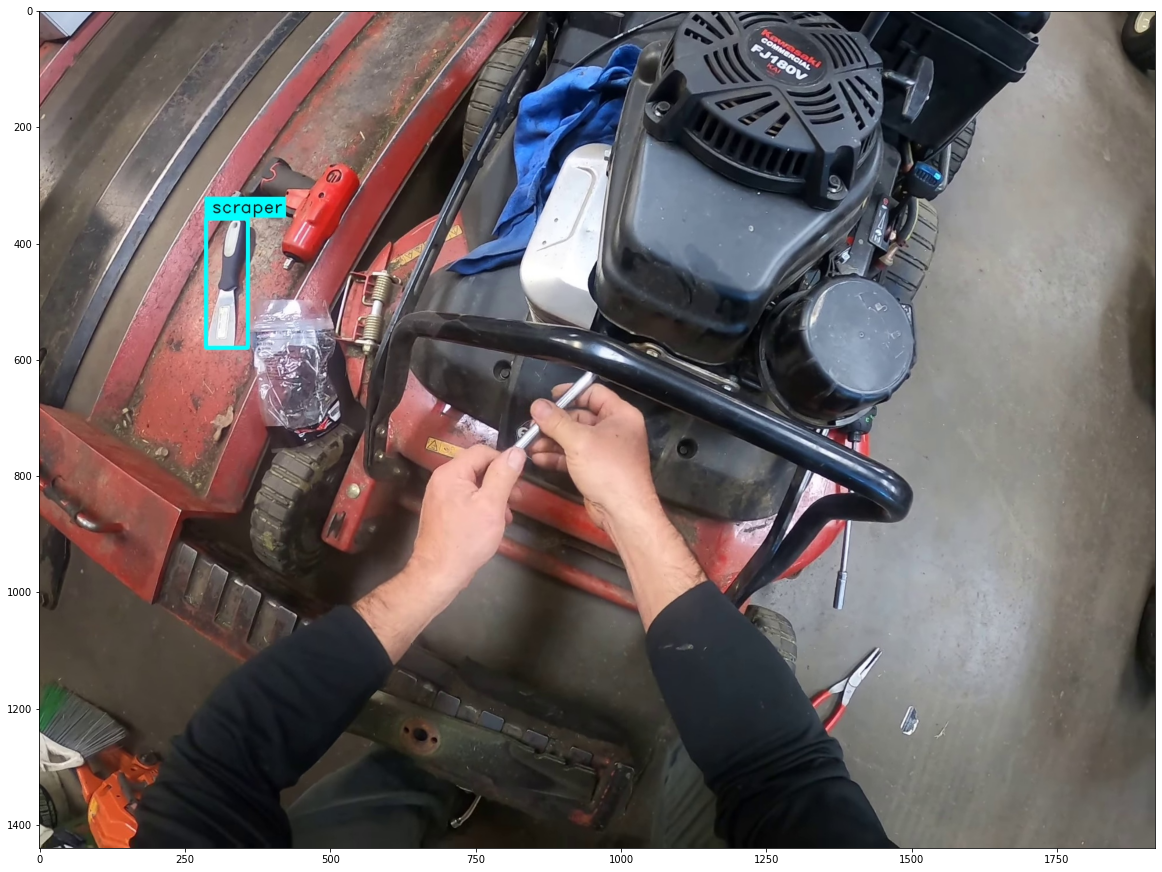

In [22]:
# Display visual crop frame
query_set = vq_video_annotations[0]['annotations'][0]['query_sets']['1']
object_frame = query_set['visual_crop']
box = {
    'object_type': query_set['object_title'],
    'bbox': {
        'x': object_frame['x'],
        'y': object_frame['y'],
        'width': object_frame['width'],
        'height': object_frame['height'],
    }
}
object_frame_path = render_frame_with_bboxes(vq_video_path, object_frame['video_frame_number'], [box])
plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(mpimg.imread(object_frame_path, format='jpeg'))
plt.show()

In [ ]:
# Display animated response track
response_track_frames = query_set['response_track']
reformatted_frames = list(map(
    lambda frame:
        {
            'frame_number': frame['video_frame_number'],
            'frame_label': f"Frame: {frame['video_frame_number']}",
            'boxes': [{
                'object_type': query_set['object_title'],
                'bbox': {
                    'x': frame['x'],
                    'y': frame['y'],
                    'width': frame['width'],
                    'height': frame['height'],
                }
            }]
        }, response_track_frames))
render_frames_animation(vq_video_path, reformatted_frames, interval=200)

# Natural Language Queries (NLQ)

[Data Overview](https://ego4d-data.org/docs/data-overview/#natural-language-queries)

In [24]:
# Load NLQ
with pathmgr.open(os.path.join(CLI_OUTPUT_DIR, VERSION, 'annotations', 'nlq_train.json'), "r") as f:
    nlq_annotations = json.load(f)
    nlq_ann_video_uids = [x["video_uid"] for x in nlq_annotations["videos"]]
nlq_video_dict = {x["video_uid"]: x["clips"] for x in nlq_annotations["videos"]}
print(f"NLQ: {len(nlq_ann_video_uids)} videos - top level: {nlq_annotations.keys()}")

NLQ: 754 videos - top level: dict_keys(['version', 'date', 'description', 'manifest', 'videos'])


In [25]:
# Sample one video
nlq_video_uid = random.sample(nlq_ann_video_uids, 1)[0]
nlq_video = videos_df[videos_df.video_uid == nlq_video_uid].iloc[0]
print(f"Sampled Video: {nlq_video}")

Sampled Video: video_uid                                        57de9622-1f5b-48e4-89b0-9f364fb1bf3c
path                                s3://ego4d-kaust/public/v1/full_scale/57de9622...
duration_sec                                                                  3060.72
scenarios                           [Playing with pets, Talking to colleagues, Wal...
split_em                                                                        train
split_av                                                                          NaN
split_fho                                                                         NaN
benchmarks                                                                       [EM]
origin_video_id                                                         041_0000_0259
video_source                                                                    kaust
device                                                             GoPro Hero Black 7
deid_scrubbed_audio                    

In [26]:
# Summarize NLQ Annotations
nlq_video_annotations = nlq_video_dict.get(nlq_video_uid)
print(f"NLQ Video: {len(nlq_video_annotations)}, clips: {nlq_video_uid}")
print(f"clip keys: {nlq_video_annotations[0].keys()}")
print(f"language_query keys: {nlq_video_annotations[0]['annotations'][0]['language_queries'][0].keys()}\n")

NLQ Video: 1, clips: 57de9622-1f5b-48e4-89b0-9f364fb1bf3c
clip keys: dict_keys(['clip_uid', 'video_start_sec', 'video_end_sec', 'video_start_frame', 'video_end_frame', 'annotations'])
language_query keys: dict_keys(['clip_start_sec', 'clip_end_sec', 'video_start_sec', 'video_end_sec', 'video_start_frame', 'video_end_frame', 'template', 'query', 'slot_x', 'verb_x', 'raw_tags'])



In [28]:
# If this errors out, make sure you used the cli to download the video with this uid
nlq_video_path = os.path.join(CLI_OUTPUT_DIR, VERSION, 'full_scale', nlq_video_uid + '.mp4')
assert os.path.exists(nlq_video_path), f"Video {nlq_video_uid} not found. Download it with the cli using: python3 -m ego4d.cli.cli --output_directory=\"<output_dir>\" --datasets full_scale --video_uids={nlq_video_uid} --yes"

In [ ]:
# Display the clip for a language query
nlq_clip = random.sample(nlq_video_annotations, 1)[0]
nlq_clip_annotations = random.sample(nlq_clip['annotations'], 1)[0]
sample_nlq_language_query = random.sample(nlq_clip_annotations['language_queries'], 1)[0]

[print(k.capitalize(),':',v) for k, v in sample_nlq_language_query.items()]

# only render 15 frames for performance
nlq_stepsize = (sample_nlq_language_query["video_end_frame"] - sample_nlq_language_query["video_start_frame"]) // 15 
render_frames_animation(
    nlq_video_path,
    [
        {"frame_number": x, "frame_label": f"Frame {x}"}
        for x in range(
            sample_nlq_language_query["video_start_frame"],
            sample_nlq_language_query["video_end_frame"],
            nlq_stepsize
        )
    ],
    interval = 400
)

***

# Audio-Visual Diarization (AV)
[Data Overview](https://ego4d-data.org/docs/benchmarks/AV-diarization/)

In [30]:
# Load AV
with pathmgr.open(os.path.join(CLI_OUTPUT_DIR, VERSION, 'annotations', 'av_train.json'), "r") as f:
    av_annotations = json.load(f)
    av_ann_video_uids = [x["video_uid"] for x in av_annotations["videos"]]
av_video_dict = {x["video_uid"]: x["clips"] for x in av_annotations["videos"]}
print(f"AV: {len(av_ann_video_uids)} videos - top level: {av_annotations.keys()}")

AV: 153 videos - top level: dict_keys(['date', 'version', 'description', 'videos'])


In [31]:
# Sample one video
av_video_uid = random.sample(av_ann_video_uids, 1)[0]
av_video = videos_df[videos_df.video_uid == av_video_uid].iloc[0]
print(f"Sampled Video: {av_video}")

Sampled Video: video_uid                                        004a1802-c546-4dcc-86ba-bf1080077017
path                                s3://ego4d-consortium-sharing/public/v1/full_s...
duration_sec                                                                  1447.29
scenarios                                                  [Grocery shopping indoors]
split_em                                                                          val
split_av                                                                        train
split_fho                                                                         NaN
benchmarks                                                                    [EM|AV]
origin_video_id                                           20191213_114909_269_0000222
video_source                                                       frl_track_1_public
device                                                                          Vuzix
deid_scrubbed_audio                    

In [32]:
# Summarize AV Annotations
av_video_annotations = av_video_dict.get(av_video_uid)
print(f"AV Video: {len(av_video_annotations)}, clips: {av_video_uid}")
print(f"clip keys: {av_video_annotations[0].keys()}")
print(f"tracked people: {len(av_video_annotations[0]['persons'])}")
print(f"person keys: {av_video_annotations[0]['persons'][0].keys()}")

AV Video: 1, clips: 004a1802-c546-4dcc-86ba-bf1080077017
clip keys: dict_keys(['clip_uid', 'source_clip_uid', 'video_uid', 'video_start_sec', 'video_end_sec', 'video_start_frame', 'video_end_frame', 'clip_start_sec', 'clip_end_sec', 'clip_start_frame', 'clip_end_frame', 'valid', 'camera_wearer', 'persons', 'missing_voice_segments', 'transcriptions', 'social_segments'])
tracked people: 10
person keys: dict_keys(['person_id', 'camera_wearer', 'tracking_paths', 'voice_segments'])


In [33]:
# Aggregate av tracking bounding boxes in an indexable dictionary
def get_av_frame_dict(av_video_annotation):
    frame_aggregator = {}
    for person in av_video_annotation['persons']:
        for tracking_path in person['tracking_paths']:
            for track in tracking_path['track']:
                frame = frame_aggregator.get(track['video_frame'])
                if frame is None:
                    frame = {
                        "frame_number": track['video_frame'],
                        "frame_label": f"Frame: {track['video_frame']}",
                        "frame_type": f"Frame: {track['video_frame']}",
                        "boxes": []
                    }
                frame['boxes'].append({
                    "object_type": tracking_path['track_id'],
                    "bbox": {
                        "x": track['x'],
                        "y": track['y'],
                        "width": track['width'],
                        "height": track['height']
                    }
                })
                frame_aggregator[track['video_frame']] = frame
    return frame_aggregator

    
# Get ordered list of frames 
def get_av_frames_with_bboxes(av_video_annotation):
    frame_dict = get_av_frame_dict(av_video_annotation)
    return sorted(list(frame_dict.values()), key=lambda x: x['frame_number'])

In [38]:
# If this errors out, make sure you used the cli to download the video with this uid
av_video_path = os.path.join(CLI_OUTPUT_DIR, VERSION, 'full_scale', av_video_uid + '.mp4')
assert os.path.exists(av_video_path), f"Video {av_video_uid} not found. Download it with the cli using: python3 -m ego4d.cli.cli --output_directory=\"<output_dir>\" --datasets full_scale --video_uids={av_video_uid} --yes"

In [39]:
# Aggregate frames from av person tracking
av_tracked_frame_dict = get_av_frame_dict(av_video_annotations[0])
av_tracked_frames = get_av_frames_with_bboxes(av_video_annotations[0])

In [ ]:
# Plot a random sample of tracked frames
plot_frames_with_bboxes(av_video_path, random.sample(av_tracked_frames, 9))

In [ ]:
# Show an animation of a subset of frames
render_frames_animation(av_video_path, av_tracked_frames[:25], interval=60)

In [ ]:
# Plot a single random tracked av frame
sample_frame = random.sample(av_tracked_frames, 1)[0]

frame_path = render_frame_with_bboxes(av_video_path, sample_frame['frame_number'], sample_frame['boxes'])
plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(mpimg.imread(frame_path, format='jpeg'))
plt.title(f"Frame: {sample_frame['frame_number']}")
plt.show()

In [ ]:
# Visualize all social segments in the video
plot_segments(av_video_annotations[0]['social_segments'], 'video_start_frame', 'video_end_frame')

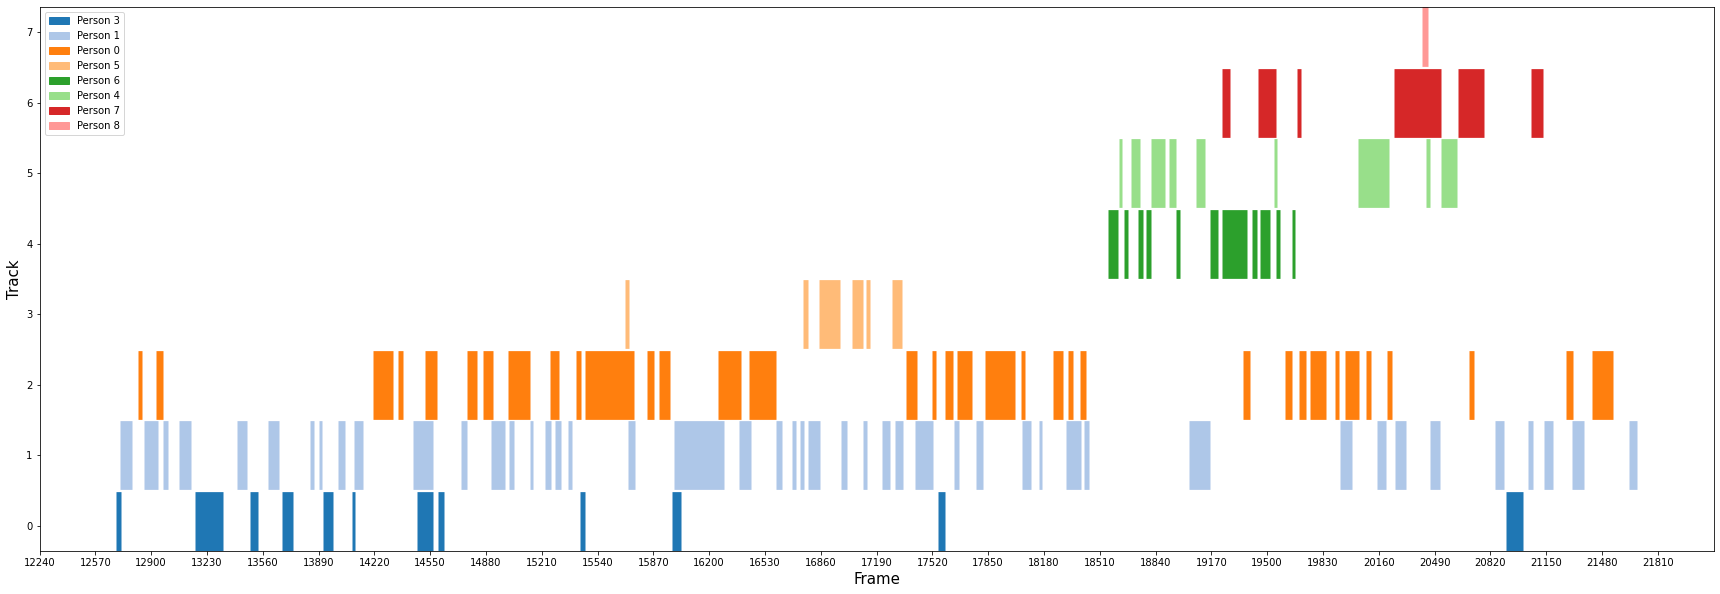

In [44]:
# Visualize all peoples' voice segments
person_voice_track_segments = [x['voice_segments'] for x in
                               av_video_annotations[0]['persons']
                               if len(x['voice_segments']) > 0]
for track in person_voice_track_segments:
    for segment in track:
        segment['label'] = f"Person {segment['person']}"
ordered_tracks = sorted(person_voice_track_segments, key=lambda x: x[0]['video_start_frame'])
plot_multitrack_segments(ordered_tracks, 'video_start_frame', 'video_end_frame', 'label')